# Running Code for UHRP

In [1]:
from collections import defaultdict
import copy
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from mondrian.masker import mask
from utility import rectangel_sampling_from_masked_data, paint_rectangle_for_masked_2d_data, paint_rectangle

## Regression task on original data with 2-D value.

In [2]:
mpg_df = shuffle(pd.read_csv("DATA/auto-mpg-6.csv", header=None), random_state=2018)
air_df = shuffle(pd.read_csv("DATA/aq-6.csv", header=None), random_state=2018)

In [44]:
'''
Function Definition
'''
def reg_metric(y_test, predict):
    '''metric for regression task'''
    # mse = mean_squared_error(y_test, predict)
    mae = mean_absolute_error(y_test ,predict)
    return mae

def high_order_feature(x, order_limit=3):
    '''Make high(3) order feature.'''
    if len(x.shape) < 2:
        x = x.reshape(-1, 1)
    bias = np.ones((x.shape[0], 1))
    x_high_order_feature = bias
    for order in range(1, order_limit+1):
        x_high_order_feature = np.hstack((x_high_order_feature, x ** order))
    return x_high_order_feature

def linear_reg(x_train, y_train, x_test, y_test):
    '''Linear regression training and evaluation'''
    from sklearn.linear_model import LinearRegression
    try:
        assert(x_train.shape[1] == x_test.shape[1])
    except Exception as e:
        print(x_train.shape, x_test.shape)
    model = LinearRegression(normalize=True)
    model.fit(x_train, y_train)
    b = model.intercept_ 
    predict = model.predict(x_test)
    mae = reg_metric(y_test, predict)
    return model, model.coef_, b, mae


def plot_1D_original_data_linear(x, y, x_test, y_test, figure="", title="", show=True, multi_dimention=False):
    '''
    Illustration for linear regression task: fitting original data.
    '''
    if not multi_dimention:
        if not isinstance(x, list):
            x = np.array(list(x))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.scatter(x, y, c='red', alpha=1, marker='+', label='Training Data')
        plt.scatter(x_test, y_test, c='green', alpha=0.6, marker='o', label='Origin Test')
        # regression
        model, paras, b, mae = linear_reg(x.reshape(-1, 1), y.reshape(-1, 1), x_test.reshape(-1,1), y_test)
        print("MAE:", mae)
        x_0 = np.min(x)
        y_0 = b + np.dot(x[0], paras[0])
        y_0 = y_0[0]
        x_last = np.max(x)
        y_last = b + np.dot(x_last, paras[0])
        y_last = y_last[0]
        plt.plot((x_0, x_last), (y_0, y_last), '--', label='regressor')
        high_x = high_order_feature(x)
        high_x_test = high_order_feature(x_test)
        model, paras, b, mae = linear_reg(high_x, y.reshape(-1, 1), high_x_test, y_test)
        print("3-order linear regression MAE:", mae)
        x_test_sorted = np.array(list(range(int(x_0), int(x_last))))
        predict_x = model.predict(high_order_feature(x_test_sorted))
        plt.plot(x_test_sorted, predict_x, '--', label='3-order regressor', color='black')
        plt.legend(loc='best')
        if show:
            plt.show()
        return mae, plt


MaE: 288.48635384310705
3-order linear regression MAE: 274.31277294963974


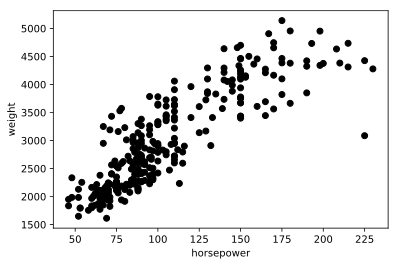

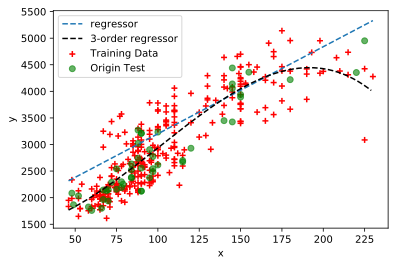

In [56]:
"""Select horsepoewr and weight from auto-pmg for 2-D painting"""
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
'''
Illustration for data distribution (x,y)

X: horsepower
Y: weight
'''
MPG_ORIGINAL_DATA_X = mpg_df[2][0:300].values
MPG_ORIGINAL_DATA_Y = mpg_df[3][0:300].values
MPG_TEST_DATA_X = mpg_df[2][300:350].values
MPG_TEST_DATA_Y = mpg_df[3][300:350].values
MPG_DATA_SET_NAME = "auto-mpg"
plt.figure(0)
plt.xlabel('horsepower')
plt.ylabel('weight')
plt.scatter(MPG_ORIGINAL_DATA_X, MPG_ORIGINAL_DATA_Y, c='black', alpha=1, marker='o', label='Original Data')
plt.figure(1)
mae_1_order = plot_1D_original_data_linear(MPG_ORIGINAL_DATA_X, MPG_ORIGINAL_DATA_Y, MPG_TEST_DATA_X, MPG_TEST_DATA_Y)


## Anonymization
Toy example to show impact of anonymization.

In [5]:
K = 5
QID_SIZE = 1
data = [[i]for i in MPG_ORIGINAL_DATA_X]
data.sort()
mpg_masked_data, eval_result = mask(data, K, QID_SIZE)
print("Anonymization with K=%d"%K)
for j in range(10):
    print(data[j][0]," ----> ",mpg_masked_data[j][0])

Anonymization with K=5
46.0  ---->  46.0~54.0
46.0  ---->  46.0~54.0
48.0  ---->  46.0~54.0
48.0  ---->  46.0~54.0
52.0  ---->  46.0~54.0
52.0  ---->  46.0~54.0
52.0  ---->  46.0~54.0
53.0  ---->  46.0~54.0
53.0  ---->  46.0~54.0
54.0  ---->  46.0~54.0


# Regression task for anonymized data
Experiments description refer to paper 5.3.

In [6]:
# load dataset as dataframe
AIR_ORIGINAL_DATA_XY = air_df[0:8000].values
AIR_TEST_DATA_XY = air_df[8000:].values
AIR_TEST_DATA_X = AIR_TEST_DATA_XY[:, :-1]
AIR_TEST_DATA_Y = AIR_TEST_DATA_XY[:, -1]

MPG_ORIGINAL_DATA_XY = mpg_df[0:300].values
MPG_TEST_DATA_XY = mpg_df[300:350].values
MPG_TEST_DATA_X = MPG_TEST_DATA_XY[:, :-1]
MPG_TEST_DATA_Y = MPG_TEST_DATA_XY[:, -1]

In [7]:
def make_model_2(state, raw_feature, current_feature_index):
    '''用 model 3 的特征构建mode2'''
    # 如果当前状态为空
    if current_feature_index >= len(raw_feature)//2:
        return state
    if not state:
        for ele in raw_feature[2*current_feature_index : 2*current_feature_index+2]:
            state.append([ele])
        return make_model_2(state, raw_feature, current_feature_index+1)
    if current_feature_index < len(raw_feature)//2:
        add_state = []
        for ele in raw_feature[2*current_feature_index: 2*current_feature_index+2]:
            for s in state:
                tmp = copy.deepcopy(s)
                tmp.append(ele)
                add_state.append(tmp)
        return make_model_2(add_state, raw_feature, current_feature_index+1)
    return state

In [37]:
def make_feature(xy_data, test_data_xy, feature_num, model=1, sampling_flag=False, ratio=0.8, k=40):
    '''
    Construct training set: anonymous numeric data
    The label attribute is in the last column as default.
    paras:
        xy_data: original training set with feature and label attributes.
        feature_num: (int) the number of features.
        model: the code number of feature engineering method.
    Returns(matrix):
        x_train, y_train, x_test, y_test
    '''
    TEST_DATA_X = test_data_xy[:, :-1]
    TEST_DATA_Y = test_data_xy[:,-1]
    # Anonymization
    masked_data, eval_result = mask(xy_data.tolist(), k, xy_data.shape[1])
    # Use Pruning Method or not
    if sampling_flag and k > 1:
        # ratio: remainder-ratio
        masked_data = rectangel_sampling_from_masked_data(masked_data, ratio=ratio)
    bias = np.ones((xy_data.shape[0], 1))
    matrix = bias
    masked_df = pd.DataFrame(masked_data)
    for col in masked_df.columns:
        new_feature_vector = np.zeros((xy_data.shape[0], 2), dtype=float)
        for row, value in enumerate(masked_df[col]):
            if k < 2:
                new_feature_vector[row, :] = [float(value), float(value)]
            else:
                if '~' in value:
                    left, right = value.split('~')
                    new_feature_vector[row, :] = [float(left), float(right)] 
                else:
                    new_feature_vector[row, :] = [float(value), float(value)] 
        matrix = np.hstack((matrix, new_feature_vector))
    if model == 3:
        # for FR-3
        x_train_model_3 = matrix[:, :feature_num*2 + 1]
        y_train_model_3 = np.mean(matrix[:, -2:], axis=1)
        # Processing the original test data, single-valued replication was extended to 2m dimension
        if len(TEST_DATA_X.shape) >= 2:
            trans_matrix = np.zeros((TEST_DATA_X.shape[1], feature_num*2), dtype=int)
            local_test_x = np.array(TEST_DATA_X)
        else:
            local_test_x = TEST_DATA_X.reshape(-1, 1)
            trans_matrix = np.zeros((1, 2), dtype=int)
        for row in range(trans_matrix.shape[0]):
            trans_matrix[row, 2*row:2*row+2] = 1
        x_test_model_3 = np.dot(local_test_x, trans_matrix)
        x_test_model_3 = np.hstack((np.ones((x_test_model_3.shape[0], 1)), x_test_model_3))
        return x_train_model_3, y_train_model_3, x_test_model_3, TEST_DATA_Y
    if model == 1 or model == 2:
        # FR-1：Replace the sample with the geometric center
        # For traning dataset
        x_train_model_1 = np.zeros((xy_data.shape[0], feature_num))
        for col in range(feature_num):
            x_train_model_1[:, col] = np.mean(matrix[:, 2*col:2*col+2], axis=1)
        x_train_model_1 = np.hstack((np.ones((xy_data.shape[0], 1)), x_train_model_1))
        y_train_model_1 = np.mean(matrix[:, -2:], axis=1)
        # test dataset.
        x_test_model_1 = np.hstack((np.ones((test_data_xy.shape[0], 1)),test_data_xy[:, :feature_num]))
        if model == 1:
            return x_train_model_1, y_train_model_1, x_test_model_1, TEST_DATA_Y
    if model == 2:
        # FR-2：add the corners
        x_train_model_2 = copy.deepcopy(x_train_model_1[:, :feature_num*2])
        new_sample_list = []
        for raw_feature in matrix:
            new_sample = make_model_2([], np.hstack((raw_feature[:feature_num*2], raw_feature[-2:])), 0)
            new_sample_list.extend(new_sample)
        np_new_sample = np.array(new_sample_list)
        np_new_sample = np.hstack((np.ones((np_new_sample.shape[0], 1)), np_new_sample))
        x_train_model_2 = np.vstack((x_train_model_2, np_new_sample[:, :-1]))
        y_train_model_2 = np.vstack((y_train_model_1.reshape(-1, 1), np_new_sample[:, -1].reshape(-1, 1)))
        return x_train_model_2, y_train_model_2, x_test_model_1, TEST_DATA_Y

## Evaluate the effect of Feature Number  and Anonymity Parameter(K)

### Experiment on Auto MPG dataset

In [14]:
def exp_5_3_a_mpg():
    feature_num = 3
    for FE in [1, 2, 3]:
        for K in [1, 2, 3, 4, 5]:
            x_train, y_train, x_test, y_test = make_feature(MPG_ORIGINAL_DATA_XY, MPG_TEST_DATA_XY, feature_num=feature_num, model=FE, sampling_flag=False, k=K)
            model, paras, b, mae = linear_reg(x_train, y_train, x_test, y_test)
            print("(K=%d)FE-%d feature[%d] MAE: "%(K, FE, feature_num), mae)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FE-H-%d feature[%d] MAE: "%(K, FE, feature_num), mae)

In [15]:
exp_5_3_a_mpg()

(K=1)FE-1 feature[3] MAE:  6.538571423907777
(K=1)FE-H-1 feature[3] MAE:  103.31185365254382
(K=2)FE-1 feature[3] MAE:  4.815384554138582
(K=2)FE-H-1 feature[3] MAE:  98.7714843158064
(K=3)FE-1 feature[3] MAE:  7.30508649272953
(K=3)FE-H-1 feature[3] MAE:  121.32024313342204
(K=4)FE-1 feature[3] MAE:  8.399831126090946
(K=4)FE-H-1 feature[3] MAE:  130.36377039754151
(K=5)FE-1 feature[3] MAE:  4.1267650343073194
(K=5)FE-H-1 feature[3] MAE:  85.64747123743956
(K=1)FE-2 feature[3] MAE:  4.2185488467981545
(K=1)FE-H-2 feature[3] MAE:  3.5722044195786173
(K=2)FE-2 feature[3] MAE:  4.125884388085981
(K=2)FE-H-2 feature[3] MAE:  3.626613422603034
(K=3)FE-2 feature[3] MAE:  4.139446425558039
(K=3)FE-H-2 feature[3] MAE:  3.706942238829853
(K=4)FE-2 feature[3] MAE:  4.116219654484123
(K=4)FE-H-2 feature[3] MAE:  3.8101317184764296
(K=5)FE-2 feature[3] MAE:  4.075643731765157
(K=5)FE-H-2 feature[3] MAE:  3.9131277395122384
(K=1)FE-3 feature[3] MAE:  3.819923193359375
(K=1)FE-H-3 feature[3] MAE:  

### Experiment on Air Quality dataset

In [16]:
def exp_5_3_a_air():
    feature_num = 3
    for FE in [1, 2, 3]:
        for K in [1, 8, 32, 64, 128]:
            x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, feature_num=feature_num, model=FE, sampling_flag=False, k=K)
            model, paras, b, mae = linear_reg(x_train, y_train, x_test, y_test)
            print("(K=%d)FE-%d feature[%d] MAE: "%(K, FE, feature_num), mae)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FE-H-%d feature[%d] MAE: "%(K, FE, feature_num), mae)

In [17]:
exp_5_3_a_air()

(K=1)FE-1 feature[3] MAE:  461.0454005429042
(K=1)FE-H-1 feature[3] MAE:  297.22155150040726
(K=8)FE-1 feature[3] MAE:  362.8115217884564
(K=8)FE-H-1 feature[3] MAE:  383.17237048662895
(K=32)FE-1 feature[3] MAE:  191.16805964550588
(K=32)FE-H-1 feature[3] MAE:  1044.9559277907722
(K=64)FE-1 feature[3] MAE:  221.54115594208974
(K=64)FE-H-1 feature[3] MAE:  5220.482762568968
(K=128)FE-1 feature[3] MAE:  194.61596066848773
(K=128)FE-H-1 feature[3] MAE:  2740.580456421336
(K=1)FE-2 feature[3] MAE:  97.21533234868728
(K=1)FE-H-2 feature[3] MAE:  99.95238584161368
(K=8)FE-2 feature[3] MAE:  94.9166969058002
(K=8)FE-H-2 feature[3] MAE:  95.30704482972229
(K=32)FE-2 feature[3] MAE:  92.73208800810497
(K=32)FE-H-2 feature[3] MAE:  94.72449619769138
(K=64)FE-2 feature[3] MAE:  101.04284031870361
(K=64)FE-H-2 feature[3] MAE:  121.02939311242044
(K=128)FE-2 feature[3] MAE:  130.1719697481649
(K=128)FE-H-2 feature[3] MAE:  141.9013100430099
(K=1)FE-3 feature[3] MAE:  86.92943017686072
(K=1)FE-H-3 

### Experiment on Auto MPG dataset with various feature number

In [22]:
def exp_5_3_b_mpg():
    K = 2
    for FE in [1, 2, 3]:
        for feature_num in [1, 2, 3, 4, 5]:
            x_train, y_train, x_test, y_test = make_feature(MPG_ORIGINAL_DATA_XY, MPG_TEST_DATA_XY, feature_num=feature_num, model=FE, sampling_flag=False, k=K)
            model, paras, b, mae = linear_reg(x_train, y_train, x_test, y_test)
            print("(K=%d)FE-%d feature[%d] MAE: "%(K, FE, feature_num), mae)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FE-H-%d feature[%d] MAE: "%(K, FE, feature_num), mae)

In [23]:
exp_5_3_b_mpg()

(K=2)FE-1 feature[1] MAE:  16.77653276424412
(K=2)FE-H-1 feature[1] MAE:  173.04251589367254
(K=2)FE-1 feature[2] MAE:  12.95808841510319
(K=2)FE-H-1 feature[2] MAE:  112.66918046860184
(K=2)FE-1 feature[3] MAE:  4.815384554138582
(K=2)FE-H-1 feature[3] MAE:  98.7714843158064
(K=2)FE-1 feature[4] MAE:  11.74944669997354
(K=2)FE-H-1 feature[4] MAE:  89.77754510694115
(K=2)FE-1 feature[5] MAE:  7.756648394189452
(K=2)FE-H-1 feature[5] MAE:  96.70239046716348
(K=2)FE-2 feature[1] MAE:  5.918646338079369
(K=2)FE-H-2 feature[1] MAE:  4.326170756524492
(K=2)FE-2 feature[2] MAE:  5.915873627786283
(K=2)FE-H-2 feature[2] MAE:  4.784931082444328
(K=2)FE-2 feature[3] MAE:  4.125884388085981
(K=2)FE-H-2 feature[3] MAE:  3.626613422603034
(K=2)FE-2 feature[4] MAE:  4.061886304987396
(K=2)FE-H-2 feature[4] MAE:  3.7132159311042336
(K=2)FE-2 feature[5] MAE:  4.01981459298759
(K=2)FE-H-2 feature[5] MAE:  3.516302463214555
(K=2)FE-3 feature[1] MAE:  3.8753055230916016
(K=2)FE-H-3 feature[1] MAE:  3.61

### Experiment on Air Quality dataset with various feature number

In [27]:
def exp_5_3_b_air(k):
    K = k
    for FE in [1, 2, 3]:
        for feature_num in [1, 2, 3, 4, 5]:
            x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, feature_num=feature_num, model=FE, sampling_flag=False, k=K)
            model, paras, b, mae = linear_reg(x_train, y_train, x_test, y_test)
            print("(K=%d)FE-%d feature[%d] MAE: "%(K, FE, feature_num), mae)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FE-H-%d feature[%d] MAE: "%(K, FE, feature_num), mae)

In [25]:
exp_5_3_b_air(16)

(K=16)FE-1 feature[1] MAE:  91.01309859181784
(K=16)FE-H-1 feature[1] MAE:  452.32921031337986
(K=16)FE-1 feature[2] MAE:  236.27543268541388
(K=16)FE-H-1 feature[2] MAE:  631.2312910002057
(K=16)FE-1 feature[3] MAE:  239.3033387845131
(K=16)FE-H-1 feature[3] MAE:  943.7862367544985
(K=16)FE-1 feature[4] MAE:  209.93409551506937
(K=16)FE-H-1 feature[4] MAE:  736.4531129354654
(K=16)FE-1 feature[5] MAE:  171.89384973724694
(K=16)FE-H-1 feature[5] MAE:  549.5716485968328
(K=16)FE-2 feature[1] MAE:  91.28005056198539
(K=16)FE-H-2 feature[1] MAE:  89.1802788852937
(K=16)FE-2 feature[2] MAE:  92.0349407105284
(K=16)FE-H-2 feature[2] MAE:  90.95864411202123
(K=16)FE-2 feature[3] MAE:  92.94693725849991
(K=16)FE-H-2 feature[3] MAE:  90.68509925600593
(K=16)FE-2 feature[4] MAE:  95.63614727769556
(K=16)FE-H-2 feature[4] MAE:  91.7336916389858
(K=16)FE-2 feature[5] MAE:  89.86298019531381
(K=16)FE-H-2 feature[5] MAE:  84.18099465302282
(K=16)FE-3 feature[1] MAE:  89.26267736091611
(K=16)FE-H-3 

In [28]:
exp_5_3_b_air(40)

(K=40)FE-1 feature[1] MAE:  86.59716858057722
(K=40)FE-H-1 feature[1] MAE:  623.3834583180467
(K=40)FE-1 feature[2] MAE:  164.01246563025
(K=40)FE-H-1 feature[2] MAE:  556.5326336933299
(K=40)FE-1 feature[3] MAE:  162.88375961829007
(K=40)FE-H-1 feature[3] MAE:  169.0790580542045
(K=40)FE-1 feature[4] MAE:  163.34615115596728
(K=40)FE-H-1 feature[4] MAE:  565.7869002752203
(K=40)FE-1 feature[5] MAE:  155.64912004475104
(K=40)FE-H-1 feature[5] MAE:  3058.5372650052777
(K=40)FE-2 feature[1] MAE:  90.5061540865514
(K=40)FE-H-2 feature[1] MAE:  92.42784351428645
(K=40)FE-2 feature[2] MAE:  91.38392122316075
(K=40)FE-H-2 feature[2] MAE:  95.75122051976496
(K=40)FE-2 feature[3] MAE:  91.55566545923104
(K=40)FE-H-2 feature[3] MAE:  91.45732639142761
(K=40)FE-2 feature[4] MAE:  93.64682048325095
(K=40)FE-H-2 feature[4] MAE:  93.76408435675754
(K=40)FE-2 feature[5] MAE:  88.8251730338652
(K=40)FE-H-2 feature[5] MAE:  89.75340989004106
(K=40)FE-3 feature[1] MAE:  89.84435583335677
(K=40)FE-H-3 f

## Evaluation of UHRP method

In [53]:
def pruning_ratio_k(k_list):
    '''
        Fix remainder-ratio, change k
    '''
    import matplotlib.pyplot as plt
    font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 30,
    }
    # global K
    # K = 40
    feature_num = 5
    mae_list_1 = []
    mae_list_high = []
    mae_list_svr = []
    mae_list_cart = []
    plt.figure(0)
    plt.xlabel('K')
    plt.ylabel('MAE')
    remainder_ratio = 0.80
    for FE in [1]:# [1,2,3]:
        mae_list_high = []
        for K in k_list:
            print("remainder_ratio:", remainder_ratio, "K:%d"%K)
            x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, 
                                                            feature_num=feature_num, model=FE, 
                                                            sampling_flag=True, ratio=remainder_ratio, k=K)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FR%d-H feature[%d] MAE: "%(K, FE, feature_num), mae)
            mae_list_high.append(mae)
        plt.plot(k_list, mae_list_high, '-', linewidth=5.0, label="pruned")
        mae_list_high = []
        for K in k_list:
            print("Left Ratio:", 1, "K:%d"%K)
            x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, 
                                                            feature_num=feature_num, model=FE, 
                                                            sampling_flag=False, k=K)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FR%d-H feature[%d] MAE: "%(K, FE, feature_num), mae)
            mae_list_high.append(mae)
        plt.plot(k_list, mae_list_high, '--', linewidth=5.0, label="no-pruning")
    plt.figure(1)
    plt.xlabel('K')
    plt.ylabel('MAE')
    remainder_ratio = 0.80
    for FE in [2]:
        mae_list_high = []
        for K in k_list:
            print("Remainder-Ratio:", remainder_ratio, "K:%d"%K)
            x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, 
                                                            feature_num=feature_num, model=FE, 
                                                            sampling_flag=True, ratio=remainder_ratio, k=K)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FR%d-H feature[%d] MAE: "%(K, FE, feature_num), mae)
            mae_list_high.append(mae)
        plt.plot(k_list, mae_list_high, '-', linewidth=5.0, label="pruned")
        mae_list_high = []
        for K in k_list:
            print("Left Ratio:", 1, "K:%d"%K)
            x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, 
                                                            feature_num=feature_num, model=FE, 
                                                            sampling_flag=False, k=K)
            x_train_h = high_order_feature(x_train)
            x_test_h = high_order_feature(x_test)
            model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
            print("(K=%d)FR%d-H feature[%d] MAE: "%(K, FE, feature_num), mae)
            mae_list_high.append(mae)
        plt.plot(k_list, mae_list_high, '--', linewidth=5.0, label="no-pruning")
    plt.figure(2)
    plt.xlabel('K')
    plt.ylabel('MAE')
    remainder_ratio = 0.99
    FE = 3
    mae_list_high = []
    for K in k_list:
        print("remainder_ratio:", remainder_ratio, "K:%d"%K)
        x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, 
                                                        feature_num=feature_num, model=FE, 
                                                        sampling_flag=True, ratio=remainder_ratio, k=K)
        x_train_h = high_order_feature(x_train)
        x_test_h = high_order_feature(x_test)
        model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
        print("(K=%d)FR%d-H feature[%d] MAE: "%(K, FE, feature_num), mae)
        mae_list_high.append(mae)
    plt.plot(k_list, mae_list_high, '-', linewidth=5.0, label="pruned")
    mae_list_high = []
    for K in k_list:
        print("Left Ratio:", 1, "K:%d"%K)
        x_train, y_train, x_test, y_test = make_feature(AIR_ORIGINAL_DATA_XY, AIR_TEST_DATA_XY, 
                                                        feature_num=feature_num, model=FE, 
                                                        sampling_flag=False, k=K)
        x_train_h = high_order_feature(x_train)
        x_test_h = high_order_feature(x_test)
        model, paras, b, mae = linear_reg(x_train_h, y_train, x_test_h, y_test)
        print("(K=%d)FR%d-H feature[%d] MAE: "%(K, FE, feature_num), mae)
        mae_list_high.append(mae)
    plt.plot(k_list, mae_list_high, '--', linewidth=5.0, label="no-pruning")
    plt.legend(loc='best')
    plt.show()

remainder_ratio: 0.8 K:20
6400 / 8000  are left after sampling!
(K=20)FR1-H feature[5] MAE:  1752.4912682573604
remainder_ratio: 0.8 K:30
6400 / 8000  are left after sampling!
(K=30)FR1-H feature[5] MAE:  1414.8602509604166
remainder_ratio: 0.8 K:40
6400 / 8000  are left after sampling!
(K=40)FR1-H feature[5] MAE:  1056.4370426115033
remainder_ratio: 0.8 K:50
6400 / 8000  are left after sampling!
(K=50)FR1-H feature[5] MAE:  688.0052374677678
remainder_ratio: 0.8 K:60
6400 / 8000  are left after sampling!
(K=60)FR1-H feature[5] MAE:  375.2579415810123
remainder_ratio: 0.8 K:70
6400 / 8000  are left after sampling!
(K=70)FR1-H feature[5] MAE:  5198.394311631944
remainder_ratio: 0.8 K:80
6400 / 8000  are left after sampling!
(K=80)FR1-H feature[5] MAE:  5423.725691559945
remainder_ratio: 0.8 K:90
6400 / 8000  are left after sampling!
(K=90)FR1-H feature[5] MAE:  4980.283979444414
remainder_ratio: 0.8 K:100
6400 / 8000  are left after sampling!
(K=100)FR1-H feature[5] MAE:  5092.680680211

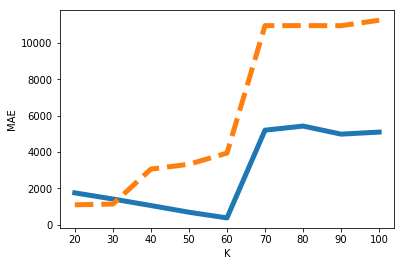

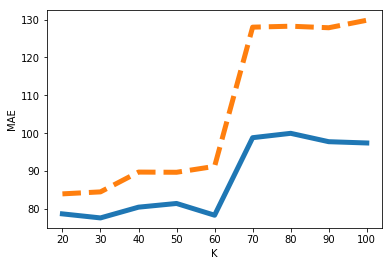

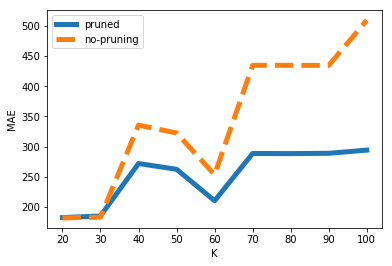

In [54]:
# Cost a few minutes.....
k_list = [20, 30, 40, 50, 60, 70, 80, 90, 100]
pruning_ratio_k(k_list)